# Part B: Fine Tuning

In Part B, your task is to pick the best pre-trained model from part A and fine-tune it on the Food101 Dataset.

You will need to experiment unfreezing on at least 2 different layers of the model.

# 1. Dataset Setup & Configuration

[1.1] Import all necessary libraries used for model training, data preprocessing, visualization, and evaluation.

In [1]:
# Import required libraries for Part B (Fine-Tuning)

# Core Python utilities
import os            # File and directory operations
import tarfile       # Extract .tar.gz dataset archives

# PyTorch core
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# TorchVision tools and models
import torchvision   # Used for visualization like torchvision.utils.make_grid()
from torchvision import transforms, models, datasets
from torchvision import transforms

# Image and visualization tools
import matplotlib.pyplot as plt            # Plotting training curves
import seaborn as sns                      # Heatmap for confusion matrix
import numpy as np                         # Numerical operations
from PIL import Image                      # Image loading and processing

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Google Colab drive access
from google.colab import drive

[1.2] Mount Google Drive to access the dataset stored in your Drive from within the Colab environment.

In [2]:
# Mount Google Drive so that files from your Google Drive can be accessed within this Colab environment.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[1.3] Extract the Food-101 dataset from the .tar.gz archive stored in Google Drive to the local Colab environment.

In [3]:
# Define the path to the .tar.gz file stored in Google Drive
tar_path = '/content/drive/MyDrive/SharedDatasets/food-101.tar.gz'

# Define the target extraction directory (within Colab's virtual file system)
extract_path = '/content/food-101'

# Open and extract all contents of the tar.gz file into the target directory
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete!")

Extraction complete!


[1.4] Explore the dataset structure and verify the number of training classes and image samples.

In [4]:
# Define the root folder where class image directories are stored
image_root = '/content/food-101/food-101/images'

# List and display the first 5 class folders (e.g., 'apple_pie', 'baklava', etc.)
print("Sample classes:", os.listdir(image_root)[:5])

# Open the train.txt file to count how many training image paths are listed
with open('/content/food-101/food-101/meta/train.txt', 'r') as f:
    train_list = f.readlines()

# Print the number of training samples referenced in the split
print("Training samples:", len(train_list))

Sample classes: ['poutine', 'sushi', 'mussels', 'gnocchi', 'miso_soup']
Training samples: 75750


[1.5] Check the available GPU type and memory status in the Colab environment.

In [5]:
# Check GPU type and memory stats (specific to Colab Pro/Premium)
!nvidia-smi

Fri Apr 25 01:47:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   40C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[1.6] Verify if CUDA is available and print the name of the GPU being used by PyTorch.

In [6]:
# Check CUDA availability using PyTorch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU (GPU not available)")

CUDA available: True
GPU name: NVIDIA L4


[1.7] Define a custom PyTorch Dataset class to load and preprocess Food-101 images with optional transformations.

In [7]:
class Food101Dataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            txt_file (str): Path to train.txt or test.txt containing relative image paths.
            root_dir (str): Path to the 'images' folder where class subfolders reside.
            transform (callable, optional): Optional image transformations to apply.
        """
        # Read image paths and append '.jpg' extension
        with open(txt_file, 'r') as file:
            self.image_paths = [line.strip() + '.jpg' for line in file]

        self.root_dir = root_dir
        self.transform = transform

        # Extract and sort class names from directory
        self.classes = sorted(os.listdir(root_dir))
        # Create mapping from class name to index
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        # Return total number of images in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get relative image path and construct full path
        rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        # Extract label from the class folder name
        label = self.class_to_idx[rel_path.split('/')[0]]

        # Load and convert image to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if defined (e.g., Resize, Normalize)
        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Dataset Preparation and Inspection

[2.1] Define image transformations, prepare the Food-101 training and test datasets, and load them using DataLoader for batch processing.

In [8]:
# Define data augmentation and normalization for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),         # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),         # Randomly flip images for augmentation
    transforms.ToTensor(),                     # Convert PIL image to PyTorch Tensor
    transforms.Normalize(                      # Normalize using ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define resizing and normalization for the test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),                    # Resize shorter side to 256
    transforms.CenterCrop(224),                # Crop center 224x224 region
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set paths to image directory and split files
data_root = '/content/food-101/food-101'
images_dir = os.path.join(data_root, 'images')
train_txt = os.path.join(data_root, 'meta/train.txt')
test_txt = os.path.join(data_root, 'meta/test.txt')

# Create training and test datasets using the custom Food101Dataset class
train_dataset = Food101Dataset(train_txt, images_dir, transform=train_transform)
test_dataset = Food101Dataset(test_txt, images_dir, transform=test_transform)

# Load the datasets using DataLoader (with batching and parallel loading)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

[2.2] Fetch a batch of training images and visualize a sample grid to verify image loading and transformations.

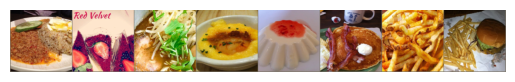

In [9]:
# Fetch one batch of images and labels from the train DataLoader
inputs, labels = next(iter(train_loader))

# Use torchvision utility to combine 8 images into a grid for display
out = torchvision.utils.make_grid(inputs[:8])

# Function to un-normalize and display the image grid
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))        # Convert from CHW to HWC format
    mean = [0.485, 0.456, 0.406]                  # Mean used in normalization
    std = [0.229, 0.224, 0.225]                   # Std used in normalization
    inp = std * inp + mean                        # Un-normalize the image
    inp = np.clip(inp, 0, 1)                      # Ensure pixel values are valid
    plt.imshow(inp)
    plt.axis('off')

# Call the imshow function to visualize the grid
imshow(out)

# 3. Model Setup

[3.1] Define a training function that handles training, validation, logging, and model checkpointing.

In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    # Ensure model is on the correct device (GPU or CPU)
    model.to(device)
    best_acc = 0.0                   # To track best validation accuracy
    train_losses = []               # To store epoch-wise training loss
    val_accuracies = []             # To store epoch-wise validation accuracy

    for epoch in range(num_epochs):
        model.train()               # Set model to training mode
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()                   # Clear previous gradients
            outputs = model(inputs)                 # Forward pass
            loss = criterion(outputs, labels)       # Compute loss
            loss.backward()                         # Backpropagation
            optimizer.step()                        # Update weights

            # Accumulate training loss
            running_loss += loss.item() * inputs.size(0)

            # Track predictions and labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute average loss and training accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)

        train_losses.append(epoch_loss)

        # Evaluation (Validation phase)
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_acc)

        # Print performance summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {epoch_loss:.4f}  "
              f"Train Acc: {epoch_acc:.4f}  Val Acc: {val_acc:.4f}")

        # Save model if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50.pth')

    print(f"\nTraining complete. Best Val Acc: {best_acc:.4f}")
    return train_losses, val_accuracies

# 4. Fine-Tuned ResNet-50

[4.1] Load ResNet-50 with pretrained weights and unfreeze the final residual block (layer4) for fine-tuning.

In [11]:
# Define computation device (use GPU if available, else fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50 with pretrained ImageNet weights
resnet_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers in the pretrained backbone to preserve general visual features
for param in resnet_ft.parameters():
    param.requires_grad = False

# Unfreeze the final residual block (layer4) to enable fine-tuning on task-specific patterns
for param in resnet_ft.layer4.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


[4.2] Define a custom classifier head for ResNet-50 and move the model to the computation device.

In [12]:
# Replace the original classifier head with a custom 3-layer fully connected block
# Matches Part A structure to allow fair comparison while enabling fine-tuning
resnet_ft.fc = nn.Sequential(
    nn.Linear(resnet_ft.fc.in_features, 512),  # First FC layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),                       # Second FC layer
    nn.ReLU(),
    nn.Linear(256, 101)                        # Output layer for 101 food classes
)

# Move the fine-tuned model to the selected computation device (GPU or CPU)
resnet_ft = resnet_ft.to(device)

[4.3] Configure the optimizer and loss function to fine-tune unfreezed layers with controlled learning.

In [13]:
# Filter and collect only the parameters that are trainable
# This includes all parameters in layer4 and the custom classifier head
trainable_params = filter(lambda p: p.requires_grad, resnet_ft.parameters())

# Use Adam optimizer for fine-tuning
# Lower learning rate is recommended to avoid large weight updates on pretrained layers
optimizer_ft = torch.optim.Adam(trainable_params, lr=1e-4)

# Define the loss function for multi-class classification (101 classes)
criterion = nn.CrossEntropyLoss()

[4.4] Train the fine-tuned ResNet-50 model using the shared training loop and log performance.

In [14]:
# Print a header to separate this training run from others in the notebook output
print("🔄 Fine-Tuning ResNet-50 (Unfrozen layer4 + head) for 5 epochs...")

# Train the fine-tuned ResNet-50 model
# This reuses the same training loop used in Part A
train_losses_ft, val_accuracies_ft = train_model(
    resnet_ft,                 # Fine-tuned ResNet-50 model
    train_loader,              # Training DataLoader
    test_loader,               # Validation DataLoader
    criterion,                 # CrossEntropyLoss
    optimizer_ft,              # Adam optimizer on unfrozen params
    num_epochs=5               # Run for 5 epochs (same as Part A for fair comparison)
)

🔄 Fine-Tuning ResNet-50 (Unfrozen layer4 + head) for 5 epochs...
Epoch [1/5]  Train Loss: 2.6257  Train Acc: 0.3834  Val Acc: 0.7058
Epoch [2/5]  Train Loss: 1.5943  Train Acc: 0.6000  Val Acc: 0.7693
Epoch [3/5]  Train Loss: 1.3636  Train Acc: 0.6525  Val Acc: 0.7971
Epoch [4/5]  Train Loss: 1.2264  Train Acc: 0.6848  Val Acc: 0.8111
Epoch [5/5]  Train Loss: 1.1221  Train Acc: 0.7100  Val Acc: 0.8189

Training complete. Best Val Acc: 0.8189


[4.5] Plot training loss and validation accuracy curves for the fine-tuned ResNet-50 model.

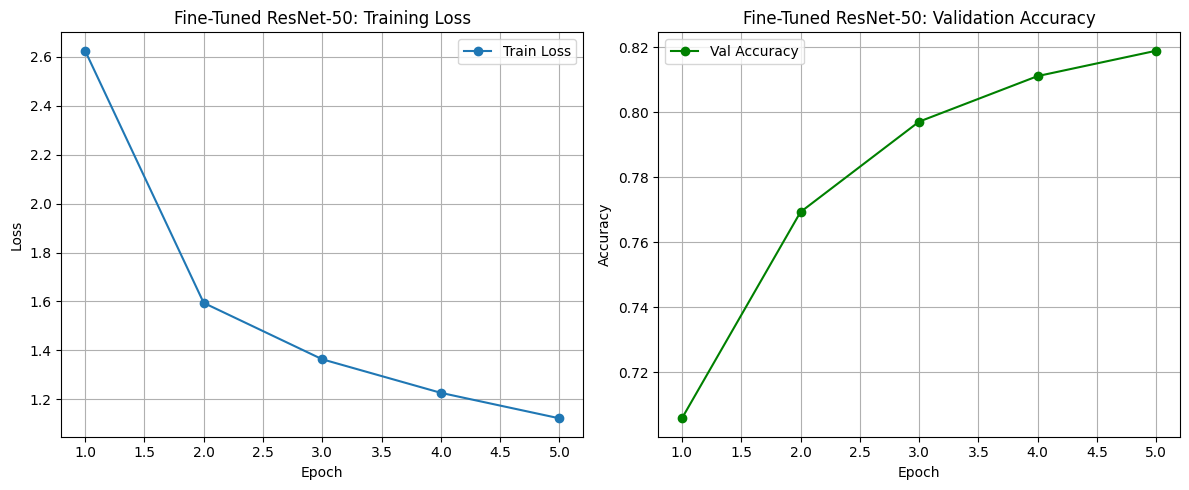

In [15]:
# Visualize training performance of the fine-tuned ResNet-50 model

# Generate epoch numbers starting from 1 (matches training logs: Epoch [1/5] ... [5/5])
epochs = list(range(1, len(train_losses_ft) + 1))

plt.figure(figsize=(12, 5))  # Create a wide figure with two side-by-side plots

# Plot: Training Loss per Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_ft, label='Train Loss', marker='o')
plt.title("Fine-Tuned ResNet-50: Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot: Validation Accuracy per Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_ft, label='Val Accuracy', marker='o', color='green')
plt.title("Fine-Tuned ResNet-50: Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Adjust layout for clean display
plt.tight_layout()
plt.show()

[4.6] Evaluate the fine-tuned ResNet-50 using a classification report and confusion matrix.

Classification Report – Fine-Tuned ResNet-50:
                         precision    recall  f1-score   support

              apple_pie       0.63      0.64      0.63       250
         baby_back_ribs       0.83      0.81      0.82       250
                baklava       0.92      0.87      0.89       250
         beef_carpaccio       0.85      0.90      0.88       250
           beef_tartare       0.84      0.76      0.80       250
             beet_salad       0.70      0.77      0.73       250
               beignets       0.88      0.90      0.89       250
               bibimbap       0.91      0.90      0.90       250
          bread_pudding       0.74      0.56      0.64       250
      breakfast_burrito       0.74      0.72      0.73       250
             bruschetta       0.83      0.70      0.76       250
           caesar_salad       0.87      0.86      0.87       250
                cannoli       0.85      0.93      0.89       250
          caprese_salad       0.84      0.8

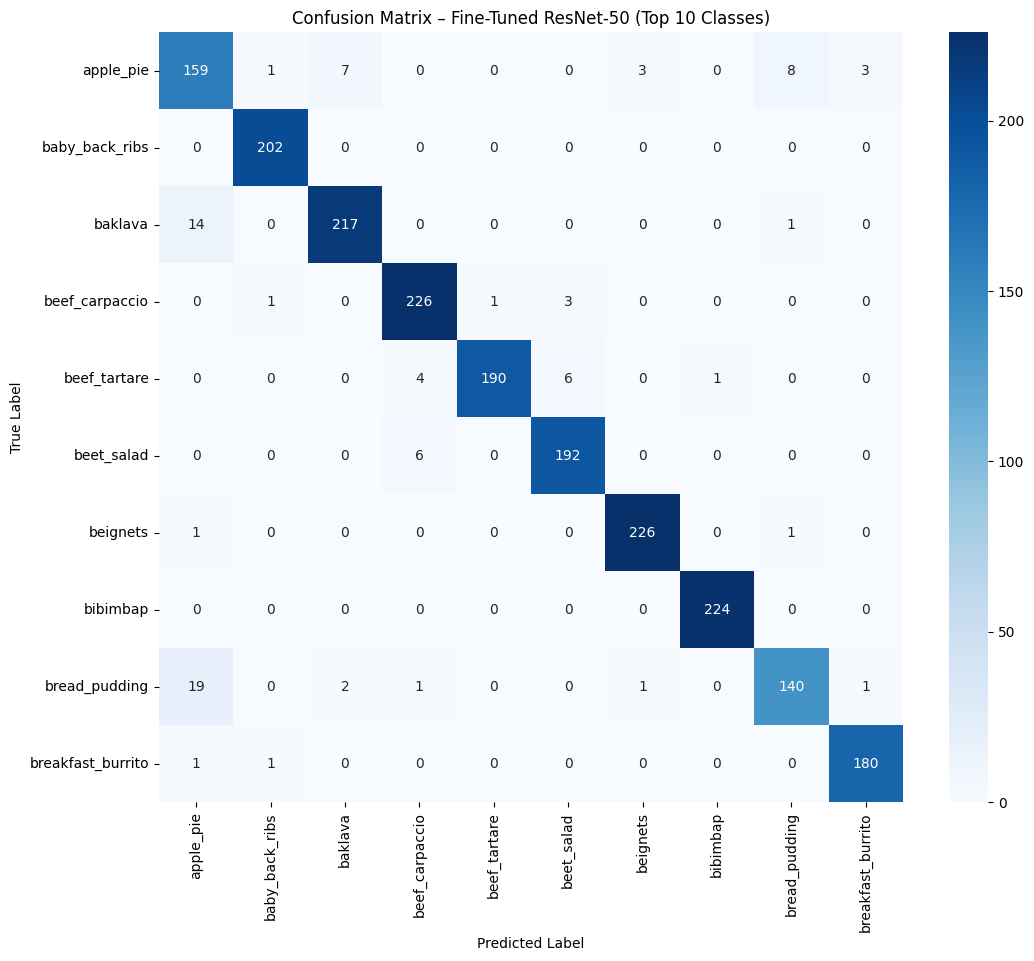

In [16]:
# Set the model to evaluation mode (disables dropout, etc.)
resnet_ft.eval()

# Initialize storage for predictions and true labels
all_preds_ft = []
all_labels_ft = []

# Generate predictions over the test set
with torch.no_grad():  # Disable gradient tracking to speed up inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_ft(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        all_preds_ft.extend(preds.cpu().numpy())
        all_labels_ft.extend(labels.cpu().numpy())

# Print classification report with precision, recall, and F1-score for each class
print("Classification Report – Fine-Tuned ResNet-50:")
print(classification_report(all_labels_ft, all_preds_ft, target_names=test_dataset.classes))

# Compute confusion matrix
cm_ft = confusion_matrix(all_labels_ft, all_preds_ft)

# Plot confusion matrix (limited to top 10 classes for clarity)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ft[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes[:10],
            yticklabels=test_dataset.classes[:10])
plt.title("Confusion Matrix – Fine-Tuned ResNet-50 (Top 10 Classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 5. Model Comparison and Summary

[5.1] Performance Overview

| Model              | Final Val Accuracy | Best Val Accuracy | Comments                          |
|-------------------|--------------------|-------------------|-----------------------------------|
| **ResNet-50**     | 0.6391             | Highest (Frozen)     | Strong backbone, solid baseline     |
| **MobileNet V3**  | 0.6189             | High              | Efficient and lightweight model     |
| **GoogLeNet**     | 0.4830             | Lower             | Older architecture, slower learner |
| **ResNet-50 FT**  | **0.8189**         | **Top Overall**  | Fine-tuning improved performance dramatically |

---

[5.2] Training Curves

- **ResNet-50 (Frozen)** showed consistent downward training loss and increasing accuracy. Performance was strong with no major signs of overfitting.
- **MobileNet V3** converged smoothly and offered competitive validation accuracy with fewer parameters.
- **GoogLeNet** started improving early but plateaued quickly, suggesting the need for fine-tuning or more epochs.
- **Fine-Tuned ResNet-50** had the most dramatic improvements in both loss and accuracy—validation accuracy jumped to **81.9%** in just 5 epochs.

---

[5.3] Classification Report Highlights

- **ResNet-50 (Frozen)** performed well on average but struggled with minority/difficult classes.
- **MobileNet V3** handled well-structured classes like `baklava`, `dumplings`, and `clam_chowder` with strong precision.
- **GoogLeNet** underperformed on challenging classes like `ceviche`, `filet_mignon`, and `tiramisu`.
- **ResNet-50 Fine-Tuned** significantly boosted precision, recall, and F1-scores across nearly all categories — especially `bibimbap`, `sashimi`, `pho`, `takoyaki`, and `spaghetti_carbonara`.

---

[5.4] Confusion Matrix Insights

- **ResNet-50 (Frozen)** showed reasonable diagonal dominance but had more confusion in similar classes.
- **MobileNet V3** was slightly better than ResNet in minimizing confusion for certain fine-grained classes.
- **GoogLeNet** confusion matrix showed more spread—highlighting difficulty in differentiating visually similar foods.
- **Fine-Tuned ResNet-50** confusion matrix was sharp and well-concentrated on the diagonals, especially in top 10 classes like `baklava`, `beignets`, and `bibimbap`.

---

[5.5] Conclusion

- **ResNet-50 (Fine-Tuned)** was the top performer across all evaluation metrics.  
- **MobileNet V3** is ideal when deploying to edge devices or needing faster inference with decent accuracy.  
- **GoogLeNet** showed its age in this comparison, underperforming on both accuracy and generalization.